In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../dataset/raw/retail_sales_nigeria.csv")
df.head()

,Customer_ID,Order_ID,Order_Date,State,Category,Sub_Category,Segment,Quantity,Sales,Discount,Cost,Profit
0,CUST-06227,ORD-100000,2023-01-31,Lagos,Furniture,Chairs,Home Office,4,439144.29,0.05,391439.63,47704.66
1,CUST-06483,ORD-100001,2024-06-26,Oyo,Office Supplies,Paper,Consumer,2,6444.69,0.20,6777.29,-332.61
2,CUST-02109,ORD-100002,2023-01-28,Kano,Furniture,Chairs,Consumer,3,76446.25,0.20,78644.94,-2198.69
3,CUST-07191,ORD-100003,2022-03-16,Lagos,Furniture,Tables,Consumer,2,92728.49,0.00,83609.53,9118.96
4,CUST-06485,ORD-100004,2020-01-22,Oyo,Technology,Phones,Home Office,5,1247073.82,0.05,927187.08,319886.74


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Customer_ID   200000 non-null  object 
 1   Order_ID      200000 non-null  object 
 2   Order_Date    200000 non-null  object 
 3   State         200000 non-null  object 
 4   Category      200000 non-null  object 
 5   Sub_Category  200000 non-null  object 
 6   Segment       200000 non-null  object 
 7   Quantity      200000 non-null  int64  
 8   Sales         200000 non-null  float64
 9   Discount      200000 non-null  float64
 10  Cost          200000 non-null  float64
 11  Profit        200000 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 18.3+ MB


In [4]:
df.isnull().sum()

Customer_ID     0
Order_ID        0
Order_Date      0
State           0
Category        0
Sub_Category    0
Segment         0
Quantity        0
Sales           0
Discount        0
Cost            0
Profit          0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
for col in df.columns:
    print(f'{col}:\n {df[col].unique()}\n')


Customer_ID:
 ['CUST-06227' 'CUST-06483' 'CUST-02109' ... 'CUST-05381' 'CUST-04985'
 'CUST-00023']

Order_ID:
 ['ORD-100000' 'ORD-100001' 'ORD-100002' ... 'ORD-299997' 'ORD-299998'
 'ORD-299999']

Order_Date:
 ['2023-01-31' '2024-06-26' '2023-01-28' ... '2023-11-22' '2023-11-15'
 '2023-10-02']

State:
 ['Lagos' 'Oyo' 'Kano' 'Plateau' 'Enugu' 'Kaduna' 'Abuja' 'Ogun' 'Anambra'
 'Rivers']

Category:
 ['Furniture' 'Office Supplies' 'Technology']

Sub_Category:
 ['Chairs' 'Paper' 'Tables' 'Phones' 'Shelves' 'Laptops' 'Binders'
 'Accessories' 'Storage']

Segment:
 ['Home Office' 'Consumer' 'Corporate']

Quantity:
 [4 2 3 5 1]

Sales:
 [439144.29   6444.69  76446.25 ...  13084.49 376192.61   7534.42]

Discount:
 [0.05 0.2  0.   0.1  0.35]

Cost:
 [391439.63   6777.29  78644.94 ...   9807.81 392994.69   5653.49]

Profit:
 [ 47704.66   -332.61  -2198.69 ...   3276.68 -16802.08   1880.93]



In [7]:
def wrangle(filepath):
    # Load data file into a dataframe
    df = pd.read_csv(filepath)

    # Convert date column to datetime datatype
    df["Order_Date"] = pd.to_datetime(df["Order_Date"])

    # Extract Year, Quarter, and Month features from the date column
    df["Year"] = df["Order_Date"].dt.year
    df["Month"] = df["Order_Date"].dt.month
    df["Month_Name"] = df["Order_Date"].dt.month_name()
    df["Quarter"] = df["Order_Date"].dt.to_period("Q").astype(str)

    # Create Profit margin column
    df["Profit_Margin"] = (df["Profit"] / df["Sales"]).round(2)

    # Highlight COVID-19 era flag
    df["COVID_Period"] = np.where(
        (df["Order_Date"] >= "2020-04-01") & (df["Order_Date"] <= "2021-06-30"),
        1,
        0
    )

    # Get Revenue per order
    df["Revenue_per_Order"] = (df["Sales"] / df["Quantity"]).round(2)

    # Categorize Discount column
    df["Discount_Band"] = pd.cut(
        df["Discount"],
        bins=[-0.01, 0.05, 0.15, 0.30, 1.0],
        labels=["No/Low", "Moderate", "High", "Very High"]
    )

    # Categorize Profit_Margin
    df["Margin_Category"] = pd.cut(
        df["Profit_Margin"],
        bins=[-1, 0.10, 0.25, 1],
        labels=["Low", "Medium", "High"]
    )
    
    # Create Order Count column
    df["Order_Count"] = (
        df.groupby("Customer_ID")["Order_ID"]
          .transform("nunique")
    )

    # Create Customer segments
    bins = [0, 1, 3, 6, float("inf")]
    labels = ["One-Time", "Occasional", "Regular", "Loyal"]
    df["Customer_Segment"] = pd.cut(df["Order_Count"], bins=bins, labels=labels)
    

    return df

In [8]:
df = wrangle("../dataset/raw/retail_sales_nigeria.csv")
df.head()

,Customer_ID,Order_ID,Order_Date,State,Category,Sub_Category,Segment,Quantity,Sales,Discount,...,Month,Month_Name,Quarter,Profit_Margin,COVID_Period,Revenue_per_Order,Discount_Band,Margin_Category,Order_Count,Customer_Segment
0,CUST-06227,ORD-100000,2023-01-31,Lagos,Furniture,Chairs,Home Office,4,439144.29,0.05,...,1,January,2023Q1,0.11,0,109786.07,No/Low,Medium,26,Loyal
1,CUST-06483,ORD-100001,2024-06-26,Oyo,Office Supplies,Paper,Consumer,2,6444.69,0.20,...,6,June,2024Q2,-0.05,0,3222.34,High,Low,31,Loyal
2,CUST-02109,ORD-100002,2023-01-28,Kano,Furniture,Chairs,Consumer,3,76446.25,0.20,...,1,January,2023Q1,-0.03,0,25482.08,High,Low,21,Loyal
3,CUST-07191,ORD-100003,2022-03-16,Lagos,Furniture,Tables,Consumer,2,92728.49,0.00,...,3,March,2022Q1,0.10,0,46364.24,No/Low,Low,37,Loyal
4,CUST-06485,ORD-100004,2020-01-22,Oyo,Technology,Phones,Home Office,5,1247073.82,0.05,...,1,January,2020Q1,0.26,0,249414.76,No/Low,High,31,Loyal


In [10]:
# Save engineered dataframe as a csv file
df.to_csv("../dataset/engineered/retail_sales_nig.csv", index=False)

### EDA

#### Seasonality Analysis

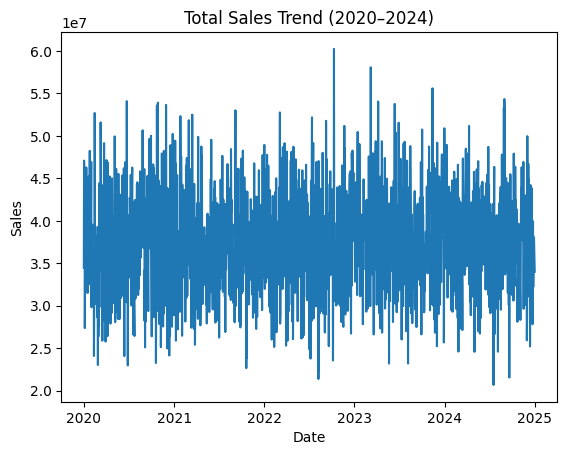

In [31]:
sales_trend = (
    df.groupby("Order_Date")["Sales"]
      .sum()
      .reset_index()
)

plt.figure()
plt.plot(sales_trend["Order_Date"], sales_trend["Sales"])
plt.title("Total Sales Trend (2020–2024)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


C:\Users\Etebom\AppData\Local\Temp\ipykernel_17836\3698708284.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby(pd.Grouper(key="Order_Date", freq="M"))["Sales"]


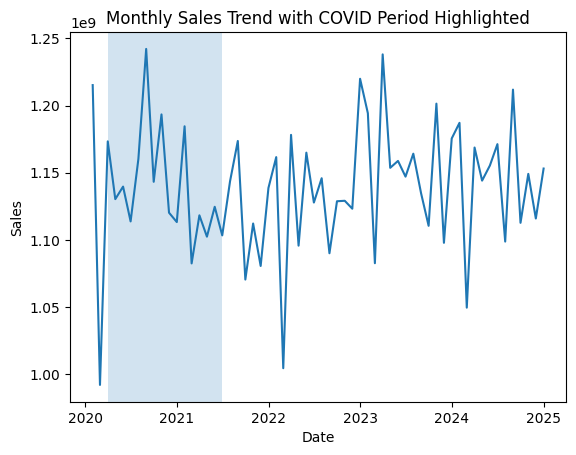

In [32]:
monthly_sales = (
    df.groupby(pd.Grouper(key="Order_Date", freq="M"))["Sales"]
      .sum()
      .reset_index()
)

plt.figure()
plt.plot(monthly_sales["Order_Date"], monthly_sales["Sales"])
plt.axvspan(
    pd.to_datetime("2020-04-01"),
    pd.to_datetime("2021-06-30"),
    alpha=0.2
)
plt.title("Monthly Sales Trend with COVID Period Highlighted")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


#### Product and Category PErformance

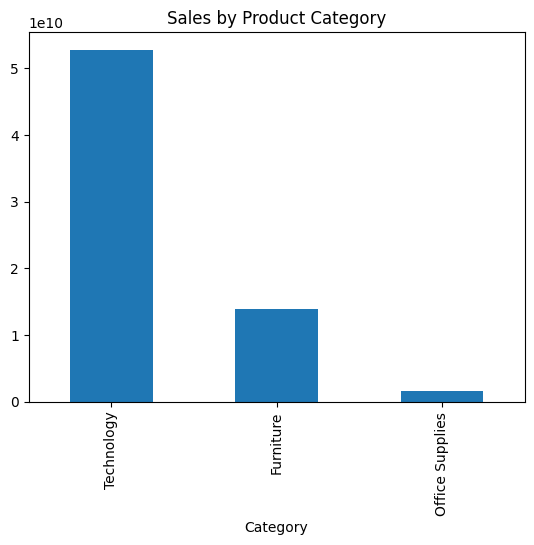

In [33]:
category_sales = (
    df.groupby("Category")["Sales"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
category_sales.plot(kind="bar")
plt.title("Sales by Product Category")
plt.show()


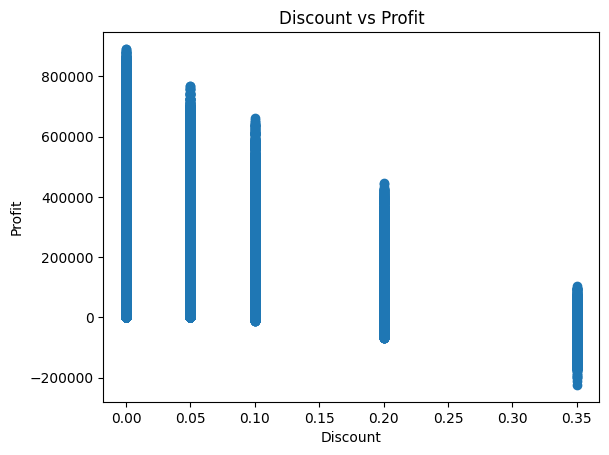

In [34]:
plt.figure()
plt.scatter(df["Discount"], df["Profit"])
plt.xlabel("Discount")
plt.ylabel("Profit")
plt.title("Discount vs Profit")
plt.show()


#### Customer Behaviour

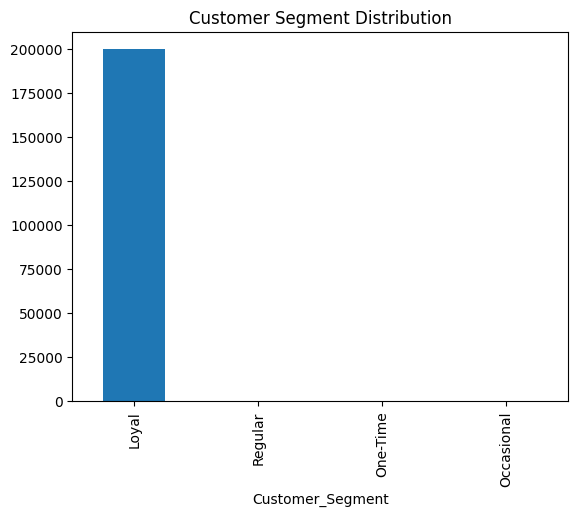

In [38]:
segment_counts = df["Customer_Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer Segment Distribution")
plt.show()


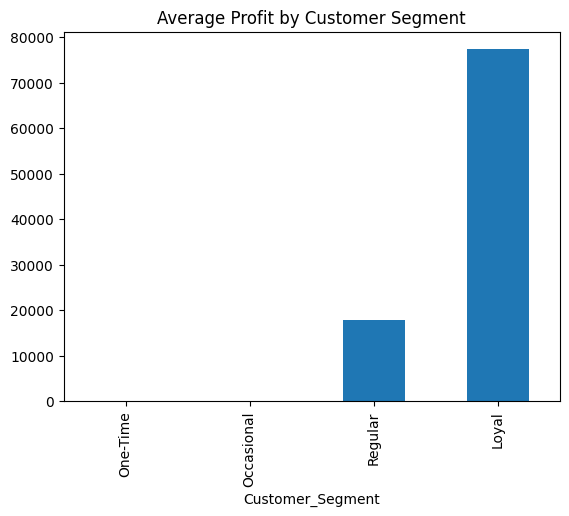

In [40]:
segment_profit = (
    df.groupby("Customer_Segment", observed=False)["Profit"]
      .mean()
)

plt.figure()
segment_profit.plot(kind="bar")
plt.title("Average Profit by Customer Segment")
plt.show()


#### COVID-19 impact Analysis

In [43]:
covid_comparison = (
    df.groupby("COVID_Period")[["Sales", "Profit"]]
      .mean()
)

covid_comparison.round(2)


,Sales,Profit
COVID_Period,,
0,341514.47,77398.90
1,341820.12,77223.25
